In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import csv
import networkx as nx
import numpy as np
import pickle
import os 
import gc

from random import randint
from gensim.models import Word2Vec
import os
%load_ext autoreload
%autoreload 2
from tensorflow import set_random_seed
from keras.models import load_model
import sys
sys.path.insert(0,'C:/Users/User/Desktop/DS_challenge/')
from GraphEmbedding.ge import DeepWalk

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from statistics import mean 
import random

import sklearn as sk
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack
from scipy.sparse import coo_matrix

import keras
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Conv1D,GlobalMaxPooling1D
from keras.layers import Dropout,Dense,Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')
import keras as k

Using TensorFlow backend.


# Load Data

In [73]:
dir_path = r'C:\Users\User\Desktop\DS_challenge\data\\'
TRAIN_FILE = dir_path + "train.csv"
TEST_FILE = dir_path + "test.csv"
GRAPH_FILE = dir_path + "edgelist.txt"
domains_path = 'C:/Users/User/Desktop/DS_challenge/data/data_science_challenge_2019/domains/'

class_labels = {'athlitismos':0, 'diaskedasi-psyxagogia':1, 'eidiseis-mme':2, 'katastimata-agores':3, 'pliroforiki-diadiktyo':4}

train_hosts = list()
train_labels = list()
with open(TRAIN_FILE, 'r') as f:
    for line in f:
        l = line.split(',')
        train_hosts.append(l[0])
        train_labels.append(l[1][:-1])

y_train_class = []
y_train_dum = np.zeros((len(train_hosts), len(class_labels)))
for i, train_label in enumerate(train_labels):
    y_train_dum[i,class_labels[train_label]] = 1
    y_train_class.append(class_labels[train_label])
    
test_hosts = list()
with open(TEST_FILE, 'r') as f:
    for line in f:
        l = line.split(',')
        test_hosts.append(l[0])

**Graph Data**

In [3]:
serialized_w2v_100_path = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/graph_emb/test_emb.pickle'
with open(serialized_w2v_100_path, 'rb') as file:
        X_train_G = pickle.load(file)
        
serialized_w2v_100_path = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/graph_emb/train_emb.pickle'
with open(serialized_w2v_100_path, 'rb') as file:
        X_test_G = pickle.load(file)

**Text Data**

In [4]:
serialized_docs_train_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/train_all/'
filenames = os.listdir(serialized_docs_train_dir)

train_data = []
y_train_tfidf = []
for idx, file in enumerate(filenames):
    with open(serialized_docs_train_dir + 'dict.pickle_' + str(idx), 'rb') as file:
        doc = pickle.load(file)
        train_data.append(doc['x_list'])               
        y_train_tfidf.append(doc['y'])
        
serialized_docs_test_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/test_all/'
filenames = os.listdir(serialized_docs_test_dir)

test_data = []
for idx, file in enumerate(filenames):
    with open(serialized_docs_test_dir + 'dict.pickle_' + str(idx), 'rb') as file:
        doc = pickle.load(file)
        test_data.append(doc['x_list'])
        
train_text = []
y_train_doc = []

train_text_idx = []
train_no_text_idx = []
train_text_index_map = {}
counter = 0
for idx, doc in enumerate(train_data):
    if len(doc) != 0:
        train_text.append(' '.join(doc))
        y_train_doc.append(y_train_tfidf[idx])
        train_text_idx.append(idx)    
        train_text_index_map[idx] = counter
        counter+=1
    else:
        train_no_text_idx.append(idx)
        
y_train_doc = np.array(y_train_doc)

test_text = []
test_text_idx = []
test_no_text_idx = []
test_text_index_map = {}
counter = 0
for idx, doc in enumerate(test_data):
    if len(doc) != 0:          
        test_text.append(' '.join(doc))
        test_text_idx.append(idx)
        test_text_index_map[idx] = counter
        counter+=1
    else:        
        test_no_text_idx.append(idx)

**TF-IDF for MLP**

In [5]:
all_text = np.concatenate((train_text, test_text))

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    decode_error='ignore',
    analyzer='word',
    ngram_range=(1, 2),
#     max_df=0.7,
#     min_df=0.05,
    lowercase=False,
    max_features=5000)
word_vectorizer.fit(all_text)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    decode_error='ignore',
    analyzer='char',
    max_df=0.5,
    min_df=0.2,
    ngram_range=(3, 5),
    max_features=3000,
    lowercase=False)
char_vectorizer.fit(all_text)

train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

**LSA on TF-IDF**

In [42]:
svd = TruncatedSVD(n_components=1000, random_state=2)
train_features_svd = svd.fit_transform(train_features)
test_features_svd = svd.transform(test_features)

### Serialize

In [88]:
'''
# Save pickles
features_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/gen_features/'
filename = 'train_tf_idf'
pickle_out = open(features_dir + filename,"wb")
pickle.dump(train_features, pickle_out)
pickle_out.close()

filename = 'test_tf_idf'
pickle_out = open(features_dir + filename,"wb")
pickle.dump(test_features, pickle_out)
pickle_out.close()

filename = 'train_LSA'
pickle_out = open(features_dir + filename,"wb")
pickle.dump(train_features_svd, pickle_out)
pickle_out.close()

filename = 'test_LSA'
pickle_out = open(features_dir + filename,"wb")
pickle.dump(test_features_svd, pickle_out)
pickle_out.close()
'''

#tfidf_8000_train
path_train_tfidf = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/gen_features/train_tf_idf'
with open(path_train_tfidf, 'rb') as file:
        train_features = pickle.load(file)
        
#tfidf_8000_test    
path_test_tfidf = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/gen_features/test_tf_idf'
with open(path_test_tfidf, 'rb') as file:
        test_features = pickle.load(file)
        
# #LSA_1000_train
# path_train_tfidf = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/gen_features/train_LSA'
# with open(path_train_tfidf, 'rb') as file:
#         train_features_svd = pickle.load(file)
        
# #LSA_100_test    
# path_test_tfidf = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/gen_features/test_LSA'
# with open(path_test_tfidf, 'rb') as file:
#         test_features_svd = pickle.load(file)


In [12]:
svd = TruncatedSVD(n_components=1000, random_state=2)
train_features_svd = svd.fit_transform(train_features)
test_features_svd = svd.transform(test_features)

In [44]:
train_features_svd.shape

(676, 676)

**MLP for LSA and tf-idf**

In [89]:
def MLP_model(
    input_size,
    optimizer,    
    classes=5,  
    epochs=100,
    batch_size=128,
    hidden_layers=1,
    units = 600,
    dropout_rate = 0.5,
    funnel = True,
    hidden_activation='relu',
    output_activation='softmax'
):
  
    # Define the seed for numpy and Tensorflow to have reproducible experiments.
    np.random.seed(23) 
    set_random_seed(452)
       
    input = Input(
        shape=(input_size,),
        name='Input'
    )
    x = input
#     x = Dropout(dropout_rate)(x)
    print(x.shape)
    # Define the hidden layers.
    for i in range(hidden_layers):
        if funnel:
            layer_units=units // (i+1)
        else: 
            layer_units=units
        x = Dense(
           units=layer_units,
           kernel_initializer='glorot_uniform',
           activation=hidden_activation,
           name='Hidden-{0:d}'.format(i + 1)
        )(x)
     #   x = BatchNormalization()(x)
     #   x = BatchNormalization(x)
        #Dropout
        x = Dropout(dropout_rate)(x)

        
    # Define the output layer.    
    output = Dense(
        units=classes,
        kernel_initializer='uniform',
        activation=output_activation,
        name='Output'
    )(x)
    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
      
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_crossentropy', 'accuracy'])
    
    return model

### Models to ensmble

In [91]:
batch_size = 128
num_classes = 5
epochs = 200
optimizer = Adam(lr=0.00023)

# model_MLP = MLP_model(
#     optimizer=optimizer,
#     input_size=X_tra.shape[1],
#     dropout_rate = 0.7,
#     hidden_layers=3,
#     units=1000,
#     funnel=True
# )

# Keras Callbacks
reducer_lr = ReduceLROnPlateau(factor = 0.00002, patience = 3, min_lr = 1e-6, verbose = -1)
early_stopper = keras.callbacks.EarlyStopping(monitor='val_categorical_crossentropy', mode='min', patience = 20) # Change 4 to 8 in the final run
model_file_name = 'tfidf_mlp'
check_pointer = keras.callbacks.ModelCheckpoint(model_file_name, monitor='val_categorical_crossentropy', mode='min', verbose = -1, save_best_only = True)  
callbacks_list = [early_stopper, reducer_lr, check_pointer]#

In [ ]:
#seeds = [random.randint(1, 20000) for _ in range(1)]

results_G = []
results_T = []

x_indicies = list(range(0, 800))
   
X_tra, X_val, y_tra, y_val = train_test_split(x_indicies, y_train_class, train_size=0.85, random_state=7, stratify=y_train_class)

# Select the Samples that have text
X_tra_text_idx = [i for i in X_tra if i in train_text_idx]     
X_val_text_idx = [i for i in X_val if i in train_text_idx]

X_tra_text_idx_map = [train_text_index_map[i] for i in X_tra_text_idx]
X_val_text_idx_map = [train_text_index_map[i] for i in X_val_text_idx]

print(len(X_tra_text_idx_map), len(X_val_text_idx_map))
#Text Samples
# y_tra_T = np.take(y_train_dum, X_tra_text_idx, axis=0)
# y_val_T = np.take(y_train_dum, X_val_text_idx, axis=0)

# X_tra_T = np.take(train_features_svd, X_tra_text_idx_map, axis=0)
# X_val_T = np.take(train_features_svd, X_val_text_idx_map, axis=0)

y_tra_T = np.take(y_train_dum, X_tra_text_idx, axis=0)
y_val_T = np.take(y_train_dum, X_val_text_idx, axis=0) #X_val[70:]

X_tra_T = train_features.tocsr()[X_tra_text_idx_map,:]
X_val_T = train_features.tocsr()[X_val_text_idx_map,:] #[X_val[70:],:]


#Graph Samples
X_tra_G = np.take(X_train_G, X_tra, axis=0)
X_val_G = np.take(X_train_G, X_val, axis=0)

y_tra_G = np.take(y_train_class ,X_tra, axis=0)
y_val_G = np.take(y_train_class ,X_val, axis=0)

y_val_G_l = np.take(y_train_dum, X_val, axis=0)


model_MLP = MLP_model(
optimizer=optimizer,
input_size=X_tra_T.shape[1],
dropout_rate = 0.8,
hidden_layers=3,
units=1100,
funnel=True
)

model_MLP.fit(x=X_tra_T,
              y=y_tra_T,          
              validation_data=(X_val_T, y_val_T), 
              epochs=200,
              verbose=1,
              batch_size=batch_size,
              callbacks = callbacks_list
         )    

svc = SVC(probability=True, C=1.45, kernel='rbf', gamma=0.035, random_state=2) #C=1.3, gamma=0.4
svc.fit(X_tra_G, y_tra_G)


y_pred_val_G = svc.predict_proba(X_val_G)    
y_pred_val_T = model_MLP.predict(X_val_T)

results_G.append(log_loss(y_val_G_l, y_pred_val_G))
results_T.append(log_loss(y_val_T, y_pred_val_T))


    
print('Mean ll')
print(mean(results_G))
print(mean(results_T))

573 103
(?, 8000)
Train on 573 samples, validate on 103 samples
Epoch 1/200
573/573 [==============================] - ETA: 6s - loss: 1.6097 - categorical_crossentropy: 1.6097 - acc: 0.21 - ETA: 2s - loss: 1.6083 - categorical_crossentropy: 1.6083 - acc: 0.22 - ETA: 0s - loss: 1.6104 - categorical_crossentropy: 1.6104 - acc: 0.21 - ETA: 0s - loss: 1.6095 - categorical_crossentropy: 1.6095 - acc: 0.21 - 2s 4ms/step - loss: 1.6117 - categorical_crossentropy: 1.6117 - acc: 0.2094 - val_loss: 1.6068 - val_categorical_crossentropy: 1.6068 - val_acc: 0.2524
Epoch 2/200
573/573 [==============================] - ETA: 0s - loss: 1.6083 - categorical_crossentropy: 1.6083 - acc: 0.20 - ETA: 0s - loss: 1.6135 - categorical_crossentropy: 1.6135 - acc: 0.19 - ETA: 0s - loss: 1.6132 - categorical_crossentropy: 1.6132 - acc: 0.17 - ETA: 0s - loss: 1.6123 - categorical_crossentropy: 1.6123 - acc: 0.17 - 0s 594us/step - loss: 1.6128 - categorical_crossentropy: 1.6128 - acc: 0.1745 - val_loss: 1.6056 -

573/573 [==============================] - ETA: 0s - loss: 1.5051 - categorical_crossentropy: 1.5051 - acc: 0.32 - ETA: 0s - loss: 1.5157 - categorical_crossentropy: 1.5157 - acc: 0.31 - ETA: 0s - loss: 1.5310 - categorical_crossentropy: 1.5310 - acc: 0.29 - ETA: 0s - loss: 1.5433 - categorical_crossentropy: 1.5433 - acc: 0.28 - 0s 857us/step - loss: 1.5513 - categorical_crossentropy: 1.5513 - acc: 0.2688 - val_loss: 1.5435 - val_categorical_crossentropy: 1.5435 - val_acc: 0.3204
Epoch 18/200
573/573 [==============================] - ETA: 0s - loss: 1.5318 - categorical_crossentropy: 1.5318 - acc: 0.23 - ETA: 0s - loss: 1.5182 - categorical_crossentropy: 1.5182 - acc: 0.25 - ETA: 0s - loss: 1.5290 - categorical_crossentropy: 1.5290 - acc: 0.25 - ETA: 0s - loss: 1.5440 - categorical_crossentropy: 1.5440 - acc: 0.24 - 1s 874us/step - loss: 1.5413 - categorical_crossentropy: 1.5413 - acc: 0.2531 - val_loss: 1.5363 - val_categorical_crossentropy: 1.5363 - val_acc: 0.3398
Epoch 19/200
573/

573/573 [==============================] - ETA: 0s - loss: 1.4230 - categorical_crossentropy: 1.4230 - acc: 0.41 - ETA: 0s - loss: 1.3762 - categorical_crossentropy: 1.3762 - acc: 0.46 - ETA: 0s - loss: 1.3829 - categorical_crossentropy: 1.3829 - acc: 0.45 - ETA: 0s - loss: 1.3802 - categorical_crossentropy: 1.3802 - acc: 0.44 - 0s 863us/step - loss: 1.3785 - categorical_crossentropy: 1.3785 - acc: 0.4433 - val_loss: 1.2810 - val_categorical_crossentropy: 1.2810 - val_acc: 0.6117
Epoch 34/200
573/573 [==============================] - ETA: 0s - loss: 1.3051 - categorical_crossentropy: 1.3051 - acc: 0.52 - ETA: 0s - loss: 1.3056 - categorical_crossentropy: 1.3056 - acc: 0.52 - ETA: 0s - loss: 1.3351 - categorical_crossentropy: 1.3351 - acc: 0.47 - ETA: 0s - loss: 1.3457 - categorical_crossentropy: 1.3457 - acc: 0.45 - 1s 895us/step - loss: 1.3478 - categorical_crossentropy: 1.3478 - acc: 0.4433 - val_loss: 1.2494 - val_categorical_crossentropy: 1.2494 - val_acc: 0.6117
Epoch 35/200
573/

573/573 [==============================] - ETA: 0s - loss: 0.9297 - categorical_crossentropy: 0.9297 - acc: 0.61 - ETA: 0s - loss: 0.9049 - categorical_crossentropy: 0.9049 - acc: 0.66 - ETA: 0s - loss: 0.9468 - categorical_crossentropy: 0.9468 - acc: 0.61 - ETA: 0s - loss: 0.9455 - categorical_crossentropy: 0.9455 - acc: 0.63 - 1s 877us/step - loss: 0.9466 - categorical_crossentropy: 0.9466 - acc: 0.6300 - val_loss: 0.9272 - val_categorical_crossentropy: 0.9272 - val_acc: 0.6505
Epoch 50/200
573/573 [==============================] - ETA: 0s - loss: 0.8585 - categorical_crossentropy: 0.8585 - acc: 0.70 - ETA: 0s - loss: 0.8818 - categorical_crossentropy: 0.8818 - acc: 0.65 - ETA: 0s - loss: 0.9089 - categorical_crossentropy: 0.9089 - acc: 0.61 - ETA: 0s - loss: 0.9087 - categorical_crossentropy: 0.9087 - acc: 0.62 - 1s 889us/step - loss: 0.9080 - categorical_crossentropy: 0.9080 - acc: 0.6283 - val_loss: 0.9140 - val_categorical_crossentropy: 0.9140 - val_acc: 0.6602
Epoch 51/200
573/

573/573 [==============================] - ETA: 0s - loss: 0.6582 - categorical_crossentropy: 0.6582 - acc: 0.72 - ETA: 0s - loss: 0.6743 - categorical_crossentropy: 0.6743 - acc: 0.71 - ETA: 0s - loss: 0.6932 - categorical_crossentropy: 0.6932 - acc: 0.70 - ETA: 0s - loss: 0.6865 - categorical_crossentropy: 0.6865 - acc: 0.70 - 0s 853us/step - loss: 0.6839 - categorical_crossentropy: 0.6839 - acc: 0.7155 - val_loss: 0.8430 - val_categorical_crossentropy: 0.8430 - val_acc: 0.6699
Epoch 66/200
573/573 [==============================] - ETA: 0s - loss: 0.7450 - categorical_crossentropy: 0.7450 - acc: 0.71 - ETA: 0s - loss: 0.7618 - categorical_crossentropy: 0.7618 - acc: 0.71 - ETA: 0s - loss: 0.7011 - categorical_crossentropy: 0.7011 - acc: 0.73 - ETA: 0s - loss: 0.6907 - categorical_crossentropy: 0.6907 - acc: 0.74 - 0s 840us/step - loss: 0.6837 - categorical_crossentropy: 0.6837 - acc: 0.7417 - val_loss: 0.8342 - val_categorical_crossentropy: 0.8342 - val_acc: 0.6796
Epoch 67/200
573/

In [87]:
#     K.clear_session()
del model_MLP
gc.collect()

137

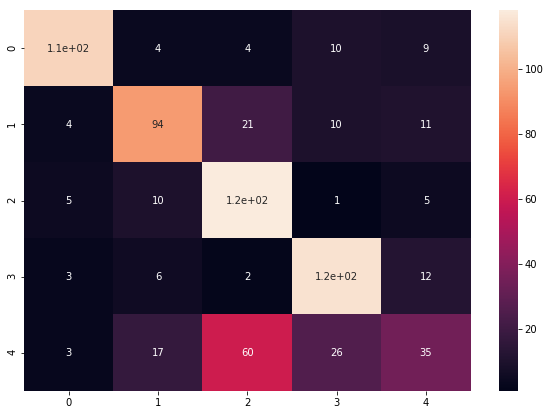

In [16]:
test_classes = {0:'athlitismos', 1:'diaskedasi-psyxagogia', 2:'eidiseis-mme',
       3:'katastimata-agores', 4:'pliroforiki-diadiktyo'}
results = [test_classes[i] for i in np.argmax(y_pred_train_G,axis=1)]
cm = confusion_matrix(y_tra,results)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

In [29]:
y_pred_test_G = svc.predict_proba(X_test_G)
y_pred_test_T = model_MLP.predict(test_features.tocsr())

In [66]:
y_test_final = ensemble_predictions(y_pred_test_G, y_pred_test_T, y_pred_test_WL)

c: 123 t: 87 g: 36


In [65]:
def ensemble_predictions(y_pred_G, y_pred_T, y_pred_WL,no_text_idx=test_no_text_idx,text_idx=test_text_idx,combine_method='avg_mix' ):
    if combine_method=='avg_mix':
        t=0
        g=0
        c=0
        y_final_pred = np.zeros((200,5))
        for idx in range(len(y_pred_G)):
            if idx in no_text_idx:
                y_final_pred[idx] = y_pred_G[idx]
            else:
                graph = y_pred_G[idx]
                index_text = text_idx.index(idx)
                text = y_pred_T[index_text]
                grakel = y_pred_WL[idx]
                if np.argmax(graph)==np.argmax(text):
                    if max(graph)>max(text):
                        y_final_pred[idx] = graph
                        g+=1
                    else:
                        y_final_pred[idx] = text
                        t+=1
                else:
                    y_final_pred[idx] = 0.4*graph + 0.3*text + 0.3*grakel

                if np.argmax(grakel)==np.argmax(y_pred_T[index_text]):
                    c+=1
    print('c:',c,'t:',t,'g:',g)
    return y_final_pred
        

In [67]:
class_labels = {'athlitismos':0, 'diaskedasi-psyxagogia':1, 'eidiseis-mme':2, 'katastimata-agores':3, 'pliroforiki-diadiktyo':4}
# Write predictions to a file
with open('sample_submission_last_2.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list(class_labels.keys())
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i,test_host in enumerate(test_hosts):
        lst = y_test_final[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

In [50]:
from random import randint
from gensim.models import Word2Vec
sys.path.insert(0,'C:/Users/User/Desktop/DS_challenge/')
from GraphEmbedding.ge import DeepWalk

In [51]:
import os
import pickle
serialized_docs_test_WL_results_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/WL_results/train/'
filenames = os.listdir(serialized_docs_test_WL_results_dir)

train_results = []
for file in filenames:
    with open(serialized_docs_test_WL_results_dir + file, 'rb') as file:
        doc = pickle.load(file)
        train_results.append(doc)              

serialized_docs_test_WL_results_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/WL_results/test/'
filenames = os.listdir(serialized_docs_test_WL_results_dir)

test_results = []
for file in filenames:
    with open(serialized_docs_test_WL_results_dir + file, 'rb') as file:
        doc = pickle.load(file)
        test_results.append(doc)              

In [52]:
import numpy as np

x_train = []
y_train_class = []
y_train_dum = []
train_probs = []
for doc in train_results:
    x_train.append(doc['cat_sum'])
    train_probs.append(doc['cat_prob'])
    y_train_class.append(np.where(doc['y']==1)[0][0])
    y_train_dum.append(doc['y'])
    
x_test = np.zeros((200,5))
x_test_prob = np.zeros((200,5))
for doc in test_results:
    x_test[doc['doc_id']] = doc['cat_sum']
    x_test_prob[doc['doc_id']] = doc['cat_prob']

In [53]:
x_indicies = list(range(0, 675))
X_tra, X_val, y_tra, y_val = train_test_split(x_indicies, y_train_class, train_size=0.90, random_state=3, stratify=y_train_class)

X_tra_WL = np.take(x_train, X_tra, axis=0)
X_val_WL = np.take(x_train, X_val, axis=0)

y_tra_WL = np.take(y_train_dum ,X_tra, axis=0)
y_val_WL = np.take(y_train_dum ,X_val, axis=0)

svc = SVC(probability=True, C=1, kernel='rbf', gamma=0.0038, random_state=2
         )
svc.fit(X_tra_WL, y_tra)

y_pred_train_WL = svc.predict_proba(X_tra_WL)
y_pred_val_WL = svc.predict_proba(X_val_WL)

print('WL res:')
print(log_loss(y_tra_WL, y_pred_train_WL))
print(log_loss(y_val_WL, y_pred_val_WL))

WL res:
0.19232843395578017
0.18366625487638547


In [55]:
y_pred_test_WL = svc.predict_proba(x_test)